In [2]:
import pandas as pd
import numpy as np
import os
import time
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
np.random.seed(0)

In [4]:
gal_RA_int = (160, 170)
gal_DEC_int = (10, 30)
gal_Z_int = (0, 0.35)

In [5]:
galaxies = pd.read_csv('ACT_06_galaxies.csv')
galaxies = galaxies[(gal_RA_int[0] <= galaxies['RA']) & (galaxies['RA'] <= gal_RA_int[1])]
galaxies = galaxies[(gal_DEC_int[0] <= galaxies['DEC']) & (galaxies['DEC'] <= gal_DEC_int[1])]
galaxies = galaxies[(gal_Z_int[0] < galaxies['Z']) & (galaxies['Z'] <= gal_Z_int[1])]
galaxies = galaxies[['RA', 'DEC', 'Z']]
galaxies.reset_index(drop=True, inplace=True)
galaxies

,RA,DEC,Z
0,164.13474,26.790246,0.000003
1,162.08272,23.984703,0.000106
2,164.76902,23.847157,0.000217
3,160.55152,15.811902,0.000261
4,169.92497,12.191744,0.000266
...,...,...,...
22932,164.78757,19.524217,0.349843
22933,163.76657,15.425962,0.349851
22934,163.45121,16.225088,0.349855
22935,167.45495,13.181810,0.349908


In [6]:
!ls Zou2022_desidr9_galaxy_photoz_cut

desidr9_galaxy_cspcat_cut_ra160_170.fits
desidr9_galaxy_cspcat_cut_ra170_180.fits
desidr9_galaxy_cspcat_cut_ra180_190.fits
desidr9_galaxy_cspcat_cut_ra190_200.fits
desidr9_galaxy_cspcat_cut_ra200_210.fits
desidr9_galaxy_cspcat_cut_ra210_220.fits
desidr9_galaxy_cspcat_cut_ra220_230.fits
desidr9_galaxy_cspcat_cut_ra230_240.fits
desidr9_galaxy_cspcat_cut_ra240_250.fits
desidr9_galaxy_cspcat_cut_ra250_260.fits
desidr9_galaxy_cspcat_cut_ra260_270.fits
desidr9_galaxy_cspcat_cut_ra270_280.fits
desidr9_galaxy_cspcat_cut_ra280_290.fits
desidr9_galaxy_cspcat_cut_ra290_300.fits
desidr9_galaxy_cspcat_cut_ra300_310.fits
desidr9_galaxy_cspcat_cut_ra310_320.fits
desidr9_galaxy_cspcat_cut_ra320_330.fits
desidr9_galaxy_cspcat_cut_ra330_340.fits
desidr9_galaxy_cspcat_cut_ra340_350.fits
desidr9_galaxy_cspcat_cut_ra350_360.fits


In [7]:
dat = Table.read(
    'Zou2022_desidr9_galaxy_photoz_cut/desidr9_galaxy_cspcat_cut_ra160_170.fits', 
    format='fits'
)
photo_160_170 = dat.to_pandas()
photo_160_170 = photo_160_170[['RA', 'DEC', 'photo_z']]
photo_160_170.columns = ['RA', 'DEC', 'Z']
photo_160_170 = photo_160_170[(gal_RA_int[0] <= photo_160_170['RA']) & (photo_160_170['RA'] <= gal_RA_int[1])]
photo_160_170 = photo_160_170[(gal_DEC_int[0] <= photo_160_170['DEC']) & (photo_160_170['DEC'] <= gal_DEC_int[1])]
photo_160_170 = photo_160_170[(gal_Z_int[0] < photo_160_170['Z']) & (photo_160_170['Z'] <= gal_Z_int[1])]
photo_160_170.reset_index(drop=True, inplace=True)
photo_160_170

,RA,DEC,Z
0,163.752814,10.576262,0.294101
1,163.753742,10.563613,0.327732
2,163.755010,10.480780,0.221377
3,163.756583,10.591307,0.145610
4,163.760412,10.383378,0.097960
...,...,...,...
390427,162.597444,25.141759,0.328303
390428,162.598110,25.276162,0.158229
390429,162.601881,25.286901,0.211617
390430,162.602897,25.159864,0.188006


In [8]:
SIGMA = 5.0
SMOOTH = 1
BOARD = 'smooth'
ANGLE = 30

In [9]:
DPS = disperse.Disperse3D(
    photo_160_170, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=None
)
DPS.count_cart_coords()

In [10]:
start = time.time()
for i in range(3):
    DPS.apply_disperse(SIGMA, SMOOTH, BOARD, ANGLE)
print((time.time() - start) / 3)

>>> delaunay_3D starts
>>> mse starts
>>> skelconv starts
>>> read_skl_ascii_RaDecZ starts
>>> delaunay_3D starts
>>> mse starts
>>> skelconv starts
>>> read_skl_ascii_RaDecZ starts
>>> delaunay_3D starts
>>> mse starts
>>> skelconv starts
>>> read_skl_ascii_RaDecZ starts
92.57711378733318


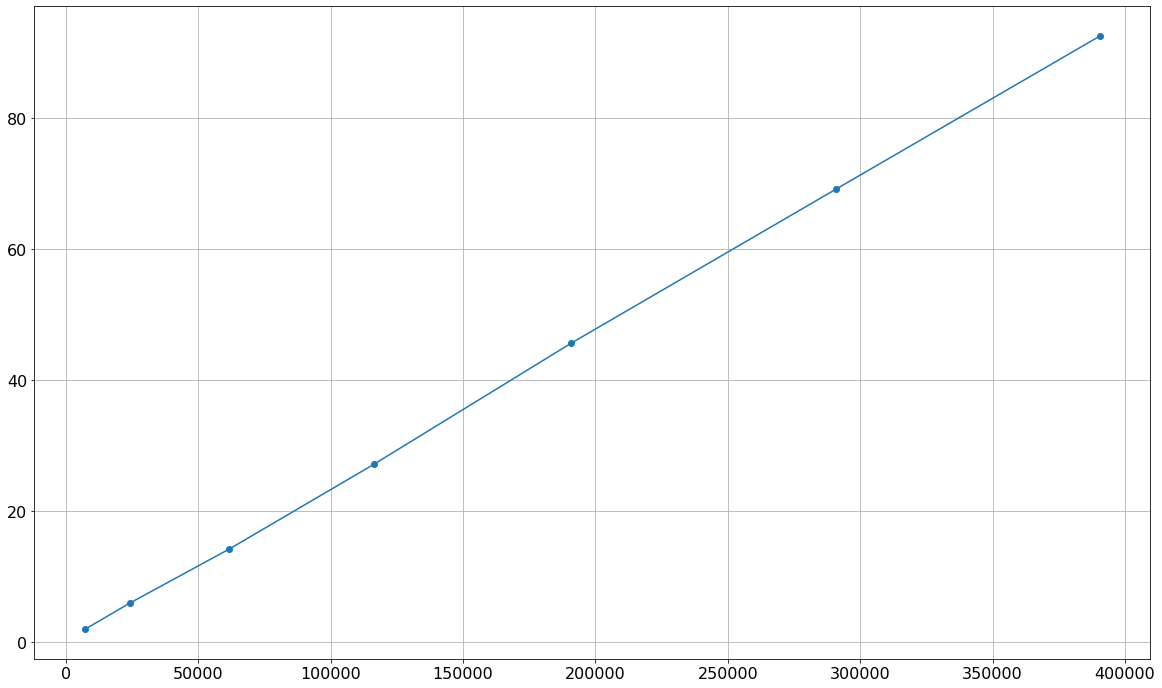

In [5]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 12))
plt.grid()

n = np.array([7349, 24296, 61687, 116267, 190854, 291030, 390432])
t = np.array([2, 6, 14.22, 27.16, 45.68, 69.25, 92.58])

k = 0.00024
b = 0
t_pred = k * n + b
plt.plot(n, t, marker='o')
# plt.plot(n, t_pred)